# Using the Angular Correlation Function

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps

from halomod.integrate_corr import AngularCF, angular_corr_gal, flat_z_dist, dxdz
from hmf.cosmo import Cosmology
from mpmath import gamma as Gamma

First we can try using the lower-level function ``angular_corr_gal``. This is the function that the high-level ``AngularCF`` calls. We can use the low-level function with arbitrary formulae for the correlation function, so we can test it out. We'll just use a pure power-law $xi(r)$. Furthermore, we use the default $n(z)$ in halomod, which is a flat $z$-distribution between $z=(0.2,0.4)$. 

In [2]:
# Define the correlation function, with r0=5.0 and gamma=1.8
def xi_power_law(r):
    return (r/5.0)**(-1.8)

# Define n(z) from the builtin default function:
nz = flat_z_dist(0.2,0.4)

1.0


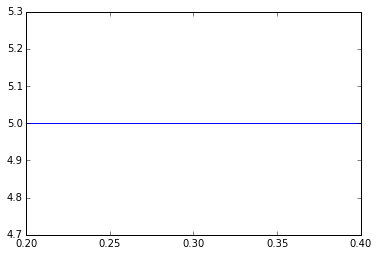

In [3]:
# Just check that the redshift dist looks ok
z = np.linspace(0.2,0.4,100)
plt.plot(z,nz(z))

# And that it integrates to 1
print simps(nz(z),z)

Once we have all these components, we can put them into the lower-level function to calculate $w(\theta)$:

In [4]:
# Make an array of angles (in radians)
theta = np.logspace(-3,0,30)*np.pi/180

wtheta = angular_corr_gal(theta,xi_power_law,nz,zmin=0.2,zmax=0.4,logu_min=-3,logu_max=3,p_of_z=True)

We can test the result, because for power-law $\xi$, there is an analytic solution to the limber equaiton:

$$ w(\theta) = A_\omega \left(\frac{\theta}{1 \rm{RAD}}\right)^{1-\gamma}$$

where

$$ A_\omega = \sqrt{\pi} r_o^\gamma \frac{\Gamma(\gamma/2 -1/2)}{\Gamma(\gamma/2)} \int_0^\infty d\bar{r}\ \  p_1^2(\bar{r}) r^{1-\gamma} $$

In [5]:
def limber_analytic_pl(theta,gamma,r0,p1,zmin,zmax,znum=100,p2=None,cosmo=Cosmology().cosmo):
    
    z = np.linspace(zmin,zmax,znum)
    x = (cosmo.comoving_distance(z)*cosmo.h).value
    
    if p2 is None:
        p2 = p1
    
    pl = 1-gamma
        
    integ = p1(z)*p2(z)*x**pl /dxdz(z,cosmo)
    
    Aw = np.sqrt(np.pi)*r0**gamma * Gamma(gamma/2-0.5)/Gamma(gamma/2) * simps(integ,z)
    return Aw*theta**pl

In [6]:
anl_sol = limber_analytic_pl(theta,1.8,5.0,nz,0.2,0.4)

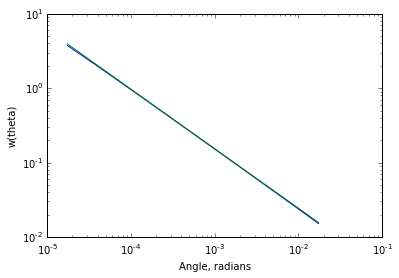

In [7]:
# Plot the analytic solution against the numerical one:
plt.plot(theta,wtheta)
plt.plot(theta,anl_sol)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Angle, radians")
plt.ylabel("w(theta)")

You can see that the numerical solutions starts to diverge from the analytic one (which is a pure power law) at btoh low and high angular separation. That's probably because our integration range in $u$ wasn't large enough. Let's try it again:

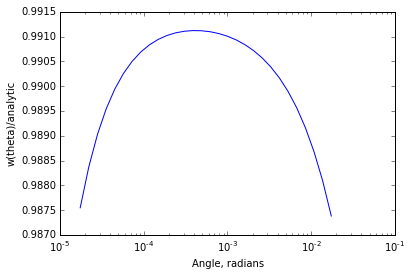

In [8]:
wtheta = wtheta = angular_corr_gal(theta,xi_power_law,nz,zmin=0.2,zmax=0.4,logu_min=-4,logu_max=4,p_of_z=True)

plt.plot(theta,wtheta/anl_sol)
plt.xscale('log')
plt.xlabel("Angle, radians")
plt.ylabel("w(theta)/analytic")

Clearly, there's still a divergence, but only of the order 0.3% at very high/low angular separation, in which case the Limber approximation breaks down anyway. There is also an offset in the normalisation by about 1%, and I'm not sure where that's coming in -- possibly in the normalisation of $n(z)$.

In any case, it does basically the right thing. Now, let's try using the high-level function, which automatically generates $\xi(r)$ based on the halo model. We'll use the same $n(z)$:

In [9]:
# To choose theta, set it in degrees then convert
theta_min = 0.001 * np.pi/180.0
theta_max = 1 * np.pi/180.0

acf = AngularCF(p1=nz,
                zmin=0.2,zmax=0.4,
                logu_min=-5,logu_max=2.5,
                rnum = 200,
                theta_min=theta_min,theta_max=theta_max,p_of_z=True)

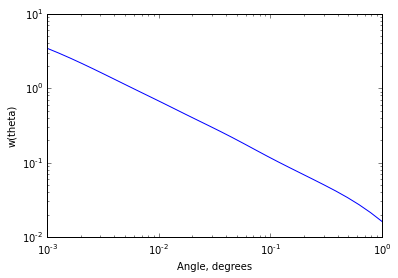

In [10]:
plt.plot(acf.theta * 180.0/np.pi,acf.angular_corr_gal)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Angle, degrees")
plt.ylabel("w(theta)")

There's nothing really to test against here, but it looks okay (and we know the algorithm works basically from the power-law test).

Just to point out a few more options you can use:

You can pass any arguments that would go to the ``HaloModel`` class:

In [11]:
acf = AngularCF(hmf_model="Tinker08",bias_model="Tinker10",
                p1=nz,
                zmin=0.2,zmax=0.4,
                logu_min=-5,logu_max=2.5,
                rnum = 200,
                theta_min=theta_min,theta_max=theta_max,p_of_z=True)
print acf.angular_corr_gal

[ 3.43001096  2.9590015   2.52963319  2.14664497  1.81102881  1.52179018
  1.27613014  1.06988409  0.89786342  0.75432999  0.633139    0.53012379
  0.44379266  0.37225915  0.31255773  0.26180859  0.21816569  0.18066594
  0.14904812  0.123101    0.10218209  0.08528394  0.07136146  0.05973903
  0.04986939  0.04139643  0.03388874  0.0271996   0.02127267  0.01613829]


Furthermore, the "p1" function, which specifies the redshift distribution, can alternatively be set as a function of radial distance. It doesn't need to be normalised, since the routine will do that for you (but you might want to anyway so that multiple calls don't have to keep normalising):

In [12]:
def radial_dist(r):
    return (r/300.0)**2 * np.exp(-r/300.0)

acf = AngularCF(hmf_model="Tinker08",bias_model="Tinker10",
                p1=radial_dist,  #Use our new window function
                zmin=0.2,zmax=0.4, #NOTE: limits are still given in terms of z
                logu_min=-5,logu_max=2.5,
                rnum = 200,
                theta_min=theta_min,theta_max=theta_max,
                p_of_z=False) #NOTE: this has to be False when the window function is n(r)

print acf.angular_corr_gal

[ 3.61359105  3.12427022  2.67573687  2.27402519  1.9206161   1.61495166
  1.35457018  1.13548508  0.9526143   0.80017485  0.67198339  0.56303244
  0.47108785  0.39494129  0.33164978  0.27804532  0.23203478  0.19241175
  0.15879925  0.13103563  0.1086142   0.09055943  0.07576555  0.06342968
  0.0529966   0.04408373  0.03622045  0.02922634  0.02299857  0.01757325]


Note also that the integral over the radial component assumes that the correlation function is the same at each redshift slice. This is of course not true over large slices. I will later implement the more general case. However, be careful to set the redshift correctly:

In [13]:
acf = AngularCF(p1=radial_dist, 
                z = 0.3, # Set redshift to middle of slice
                zmin=0.2,zmax=0.4,
                logu_min=-5,logu_max=2.5,
                rnum = 200,
                theta_min=theta_min,theta_max=theta_max,
                p_of_z=False) #NOTE: this has to be False when the window function is n(r)

print acf.angular_corr_gal

[ 3.81151249  3.26391038  2.763426    2.31689639  1.92597172  1.58996381
  1.30601742  1.06956373  0.87482362  0.71525914  0.58390311  0.47518454
  0.38679696  0.31756807  0.26369529  0.22065933  0.18533223  0.15590473
  0.13115867  0.11000995  0.09168262  0.07601248  0.06307899  0.05264448
  0.04404828  0.03671911  0.0302019   0.02438307  0.01919834  0.01467546]


/home/steven/anaconda2/lib/python2.7/site-packages/hmf-2.0.0-py2.7.egg/hmf/hmf.py:498: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 638 but corresponding boolean dimension is 627
  ngtm_temp[np.logical_not(np.isnan(dndm[dndm>0]))] = ngtm
